In this project, we predict concrete strength using eight other predictor variables. We implement feature engineering, hyperparameter tuning, and cross-validation in aims of boosting our models' performance

# EDA

In [1]:
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('concrete.csv')
df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

In [3]:
#The variables slag, ash, superplastic all range from 0 to a certain value 
#The minimum and maximum ages are 1 and 365, respectively. The average age of the concrete is approx 45
df.describe()

cement         slag          ash        water  superplastic  \
count  1030.000000  1030.000000  1030.000000  1030.000000   1030.000000   
mean    281.167864    73.895825    54.188350   181.567282      6.204660   
std     104.506364    86.279342    63.997004    21.354219      5.973841   
min     102.000000     0.000000     0.000000   121.800000      0.000000   
25%     192.375000     0.000000     0.000000   164.900000      0.000000   
50%     272.900000    22.000000     0.000000   185.000000      6.400000   
75%     350.000000   142.950000   118.300000   192.000000     10.200000   
max     540.000000   359.400000   200.100000   247.000000     32.200000   

         coarseagg      fineagg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    45.662136    35.817961  
std      77.753954    80.175980    63.169912    16.705742  
min     801.000000   594.000000     1.000000     2.330000  
25%     932.000000   730.950000     7.000000    23.710000  
50%     968.000000   779.500000    28.000000    34.445000  
75%    1029.400000   824.000000    56.000000    46.135000  
max    1145.000000   992.600000   365.000000    82.600000

In [4]:
#There are no null values in this dataset
df.isnull().any()

cement          False
slag            False
ash             False
water           False
superplastic    False
coarseagg       False
fineagg         False
age             False
strength        False
dtype: bool

In [5]:
#All data types are float except for age. 'strength' is the variable we wish to predict
#There are 1030 observations and 9 columns. This seems to be a quite small dataset
''' The first seven variables in this list are measured in: kg in a m3 mixture. Age is measured in days 
(from 1-365). Concrete strength is measured in MPa'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


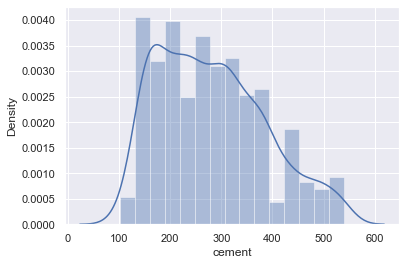

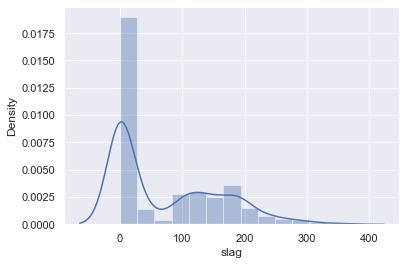

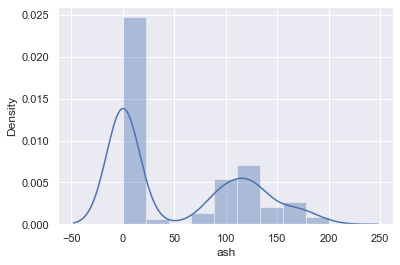

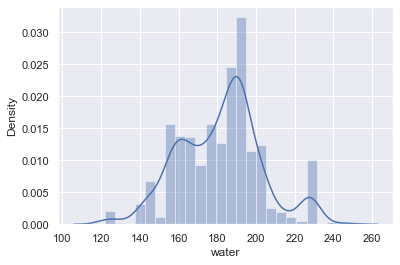

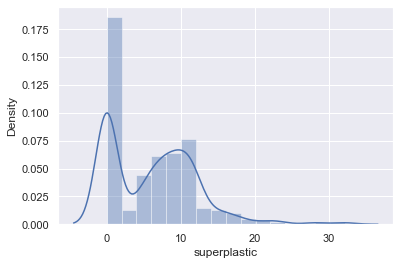

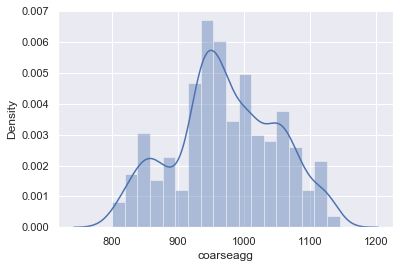

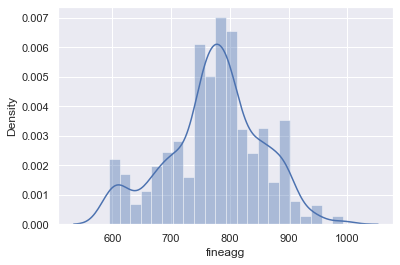

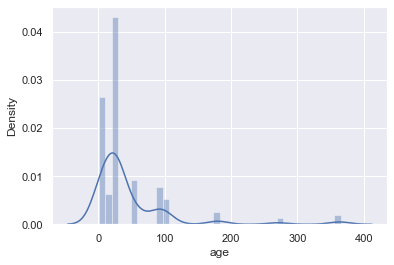

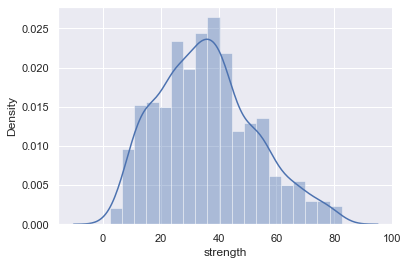

In [6]:
#The variables cement and strength are very roughly normally distributed
#The variables slag, ash, water, superplastic, and courseagg seem to have roughly bimodal distributions
#
import warnings
warnings.filterwarnings('ignore')
for i in df.columns:
    sns.distplot(df[i])
    plt.show()

Since the data only has 1,030 observations, I will not be stringent on removing outliers in order to prevent overfitting. The superplastic variable and age variable both are strongly right skewed. However, I will choose to remove the few observations in age that are past two standard deviations from the mean, i.e past 171 days in age

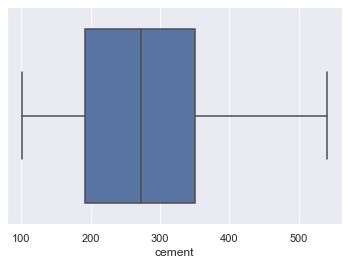

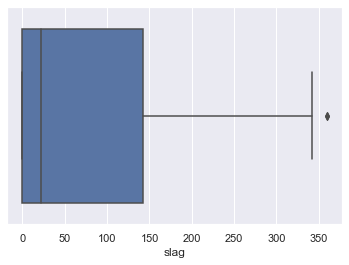

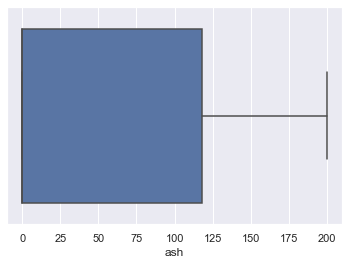

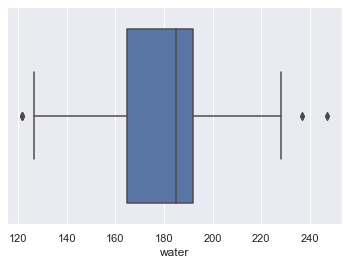

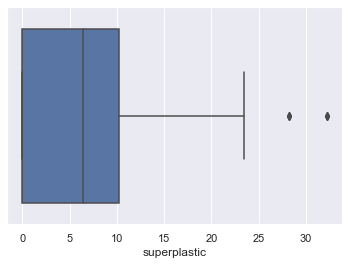

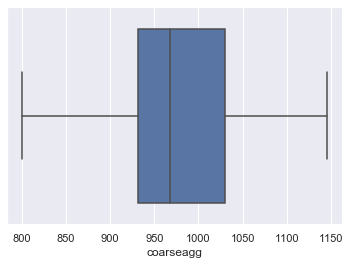

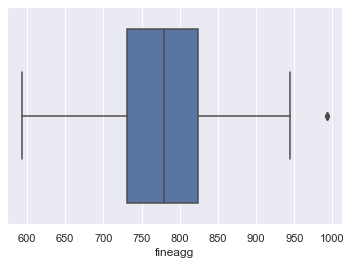

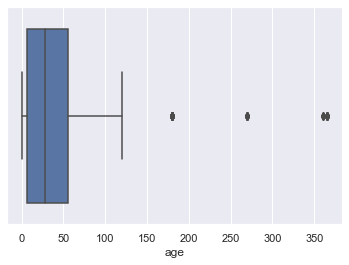

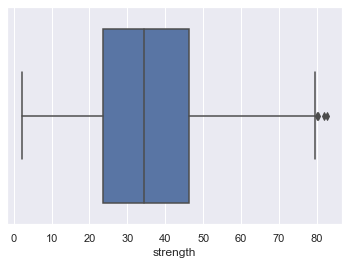

In [7]:
#We note that the highest number of outliers seems to be present with age
#We choose to remove outliers for 'age' and keep all other observations due to the small size of the dataset
for i in df.columns:
    sns.boxplot(x=df[i])
    plt.show()

# Bivariate Analysis

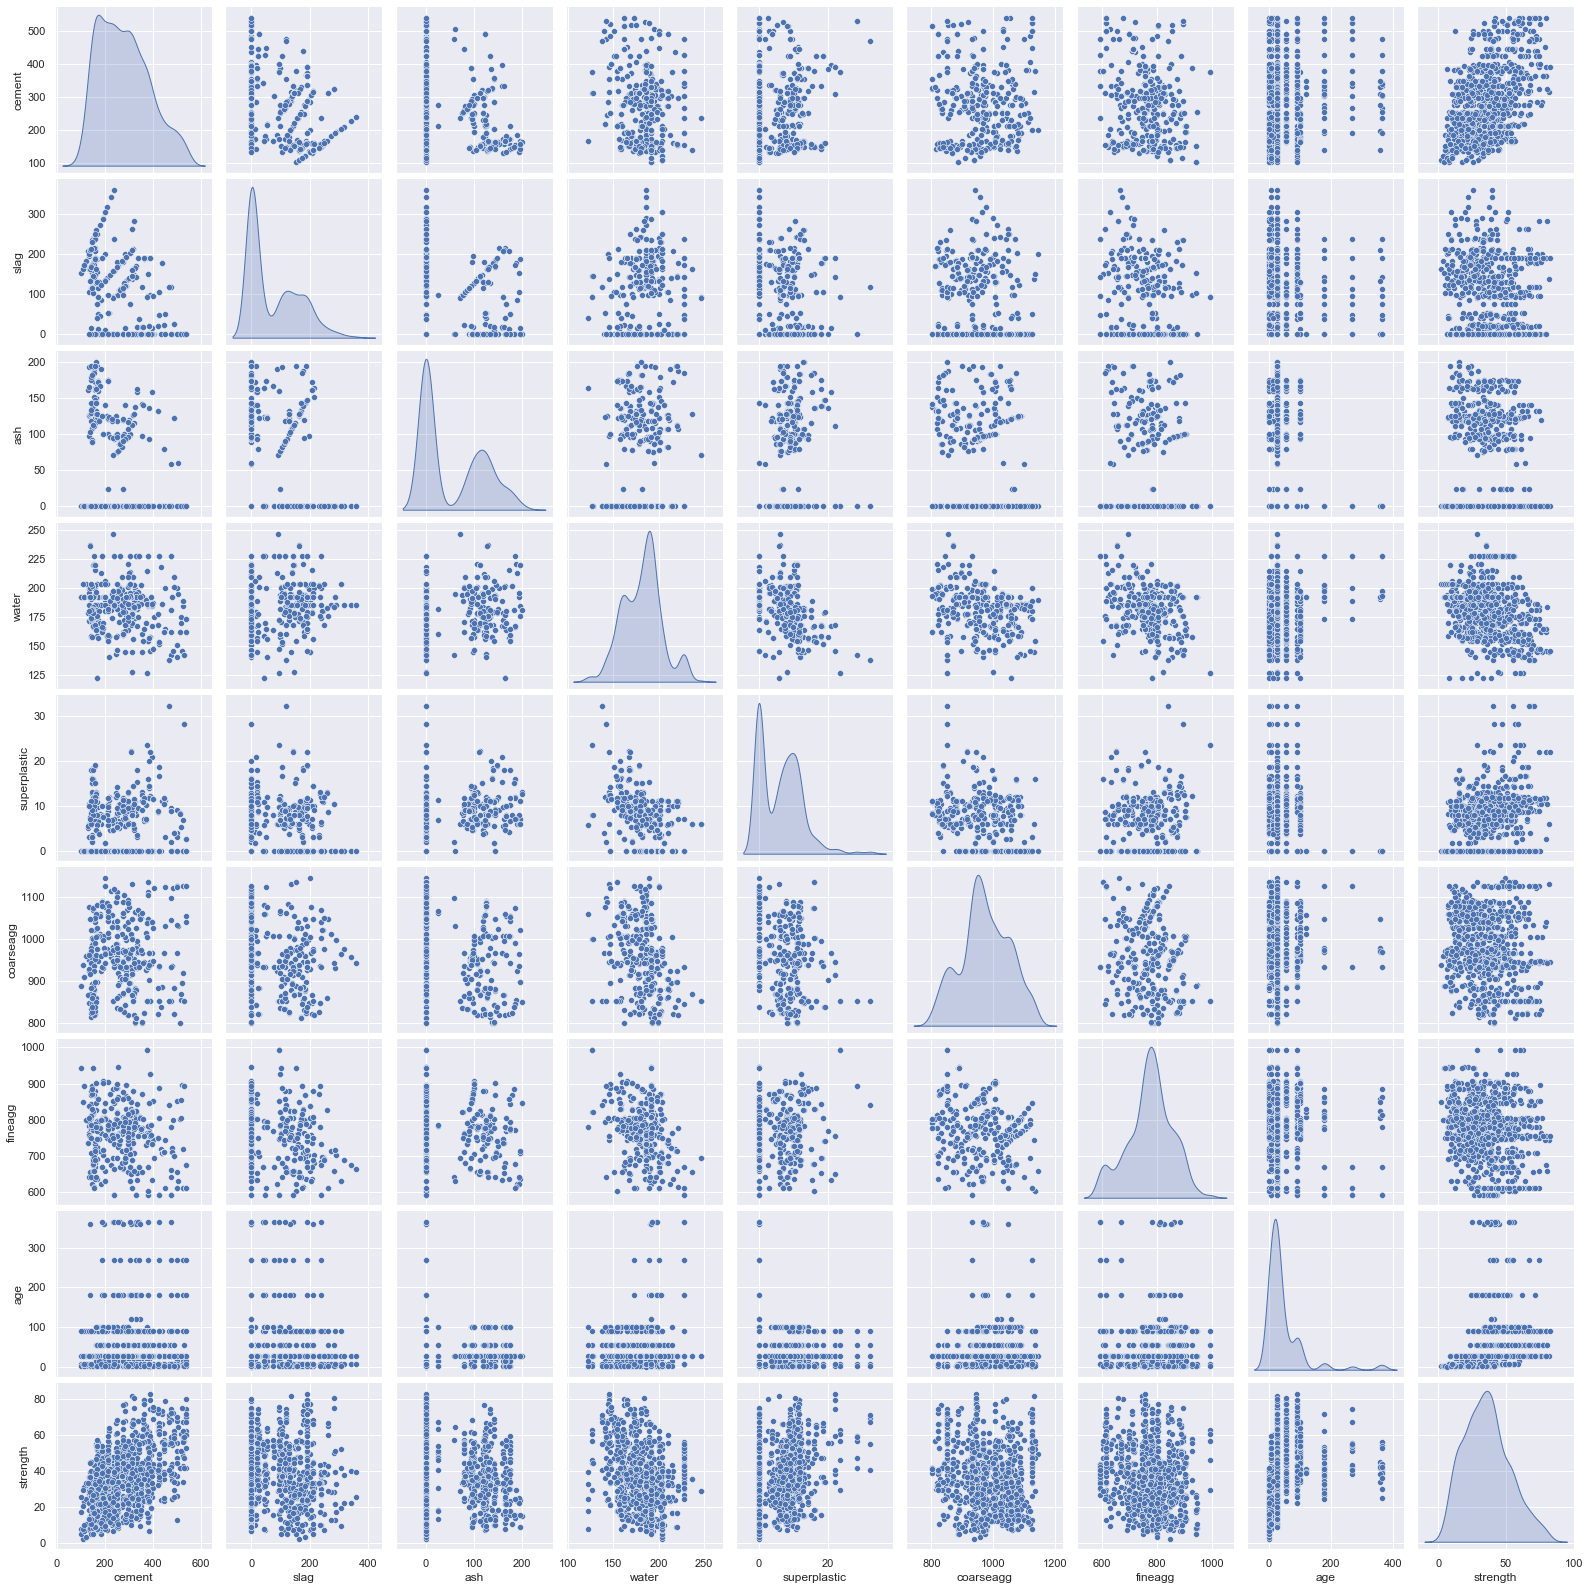

In [8]:
#It seems that none of the predictor variables have a strong correlation with the 'strength' variable
#There may be slight positive correlation between superplastic & strength, superplastic, & water
sns.pairplot(df, diag_kind='kde')

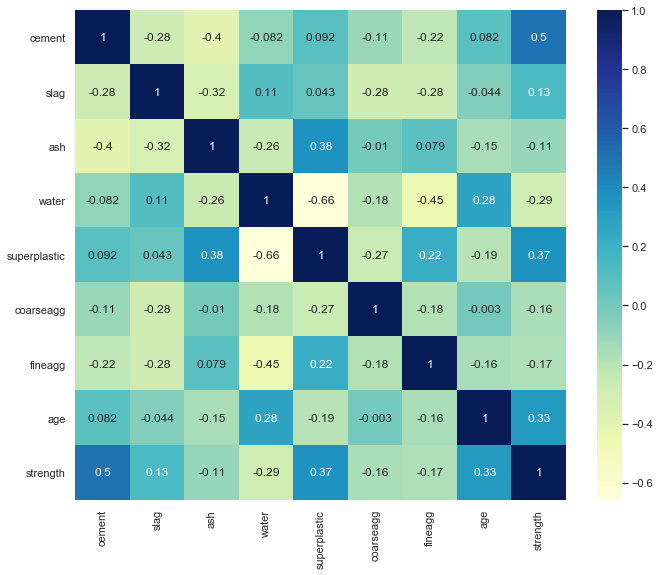

In [9]:
f, ax = plt.subplots(figsize=(11, 9))
corr = df.corr()
heatmap = sns.heatmap(corr, cmap="YlGnBu", annot= True)

# Feature Engineering and EDA Continued

From this heatmap, I noted that there is little to no correlation between predictor variables in this dataset. I see that cement, superplastic, and age are the variables most correlated with strength and thus choose to keep hese variables in the analysis. There is no need to remove any variables since we are working with a small number of features that do not seem to have covariance. Before continuing with bivariate analysis, I will do some feature engineering to create categorical variables for the age, water, and courseagg variables to see if I can increase their correlation values with the predictor variable

In [10]:
#4 categories are made for these three variables and inserted back into the dataframe
#These intervals were created based on the quartiles found in the beginning of the analysis
age_cat = pd.cut(df.age,bins=[-1,8,29,57,366],labels=['Recent','Average','Older','Very Old'])
water_cat = pd.cut(df.water,bins=[121.6,164.8,186,193,248],labels=['Low','Average','High','Very High'])
coarseagg_cat = pd.cut(df.coarseagg,bins=[800,933,969,1029.5,1146],labels=['Low','Average','High','Very High'])
df.insert(8, 'age_cat', age_cat)
df.insert(4, 'water_cat', water_cat)
df.insert(6, 'coarseagg_cat', coarseagg_cat)
df.head()

cement   slag    ash  water  water_cat  superplastic coarseagg_cat  \
0   141.3  212.0    0.0  203.5  Very High           0.0          High   
1   168.9   42.2  124.3  158.3        Low          10.8     Very High   
2   250.0    0.0   95.7  187.4       High           5.5       Average   
3   266.0  114.0    0.0  228.0  Very High           0.0           Low   
4   154.8  183.4    0.0  193.3  Very High           9.1     Very High   

   coarseagg  fineagg  age  age_cat  strength  
0      971.8    748.5   28  Average     29.89  
1     1080.8    796.2   14  Average     23.51  
2      956.9    861.2   28  Average     29.22  
3      932.0    670.0   28  Average     45.85  
4     1047.4    696.7   28  Average     18.29

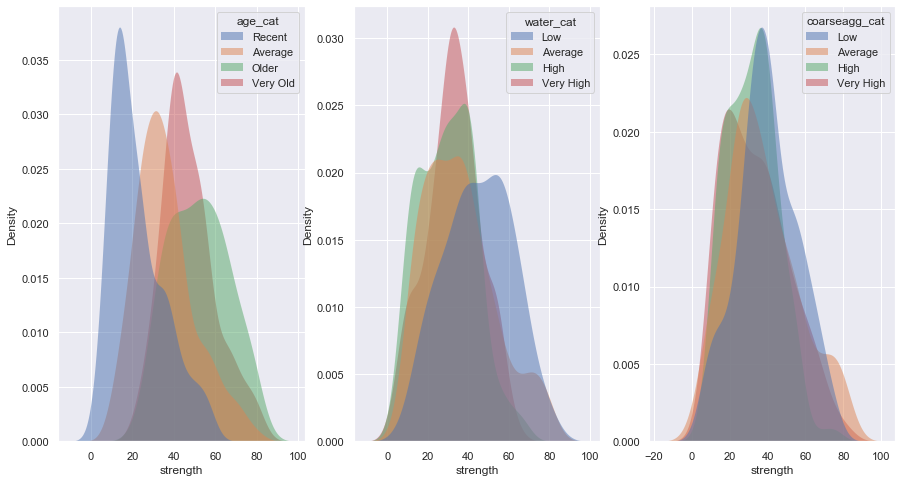

In [11]:
#This is interesting. It appears that although younger aged concrete tends to have less strength
#Older concrete tends to have more strength than very old concrete as well
#It seems that the amount of water does not seem to have a big impact on concrete strength 
    #since the densities for the groups overlap. Low water may possibly correlate with strength however
#Courseagg levels do not seem to effect concrete strength either
f, ax = plt.subplots(figsize=(15, 8), ncols=3)
sns.kdeplot(data=df, x="strength", hue="age_cat",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, ax=ax[0])
sns.kdeplot(data=df, x="strength", hue="water_cat",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, ax=ax[1])
sns.kdeplot(data=df, x="strength", hue="coarseagg_cat",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, ax=ax[2])

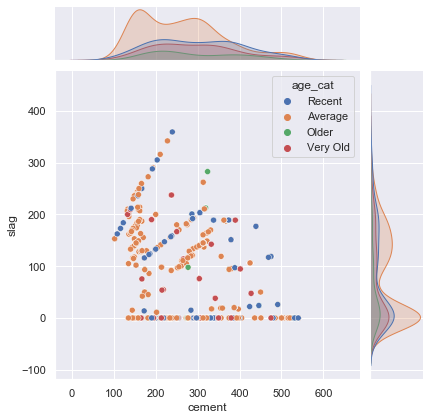

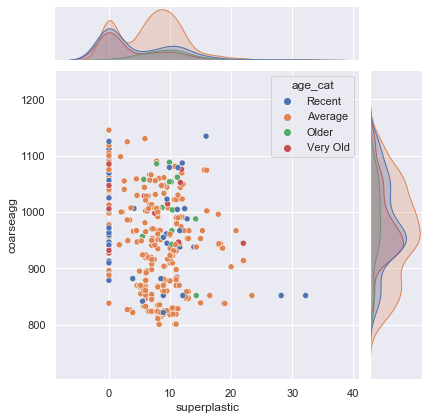

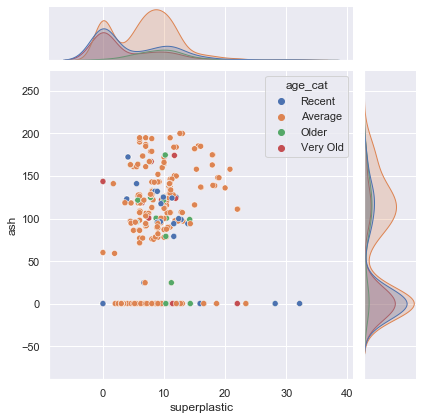

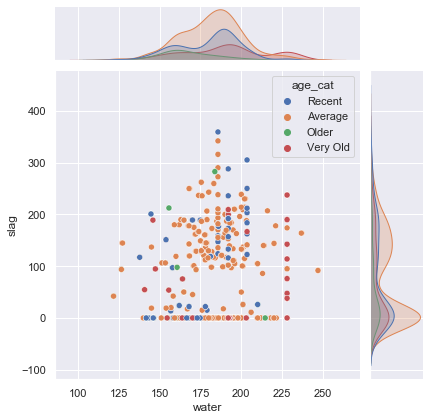

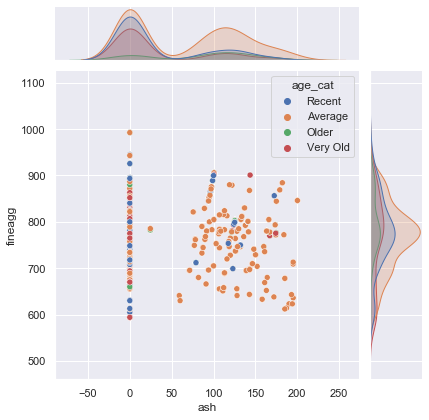

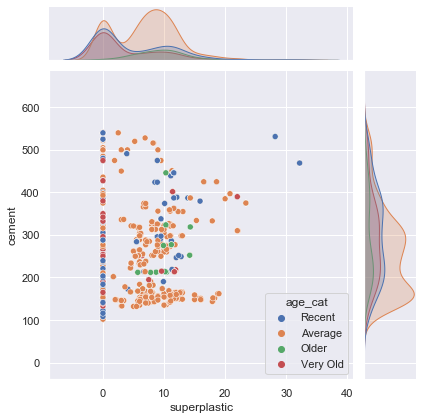

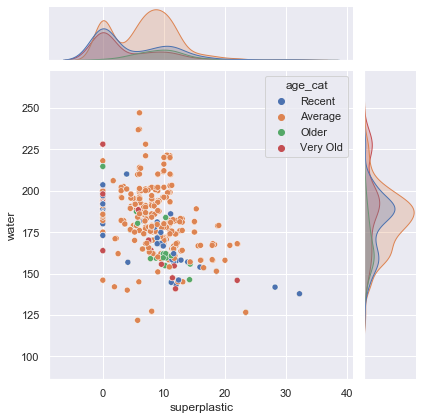

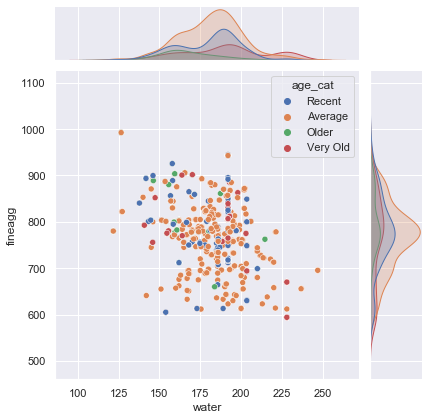

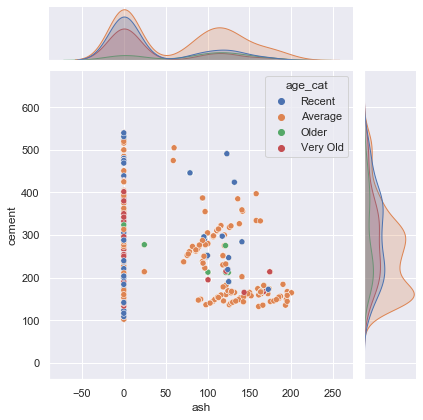

In [12]:
#We explore the categorical age variable further here using jointplots
#It seems that for all age groups, the slag variable has a peak at 0 with varying cement values
#I note that the average age group tends to have the most variability across numerical variables
#However, all age groups tend to follow similar patterns for each numerical variables looking at the KDE
sns.jointplot(data=df, x="cement", y="slag", hue="age_cat")
sns.jointplot(data=df, x="superplastic", y="coarseagg", hue="age_cat")
sns.jointplot(data=df, x="superplastic", y="ash", hue="age_cat")
sns.jointplot(data=df, x="water", y="slag", hue="age_cat")
sns.jointplot(data=df, x="ash", y="fineagg", hue="age_cat")
sns.jointplot(data=df, x="superplastic", y="cement", hue="age_cat")
sns.jointplot(data=df, x="superplastic", y="water", hue="age_cat")
sns.jointplot(data=df, x="water", y="fineagg", hue="age_cat")
sns.jointplot(data=df, x="ash", y="cement", hue="age_cat")

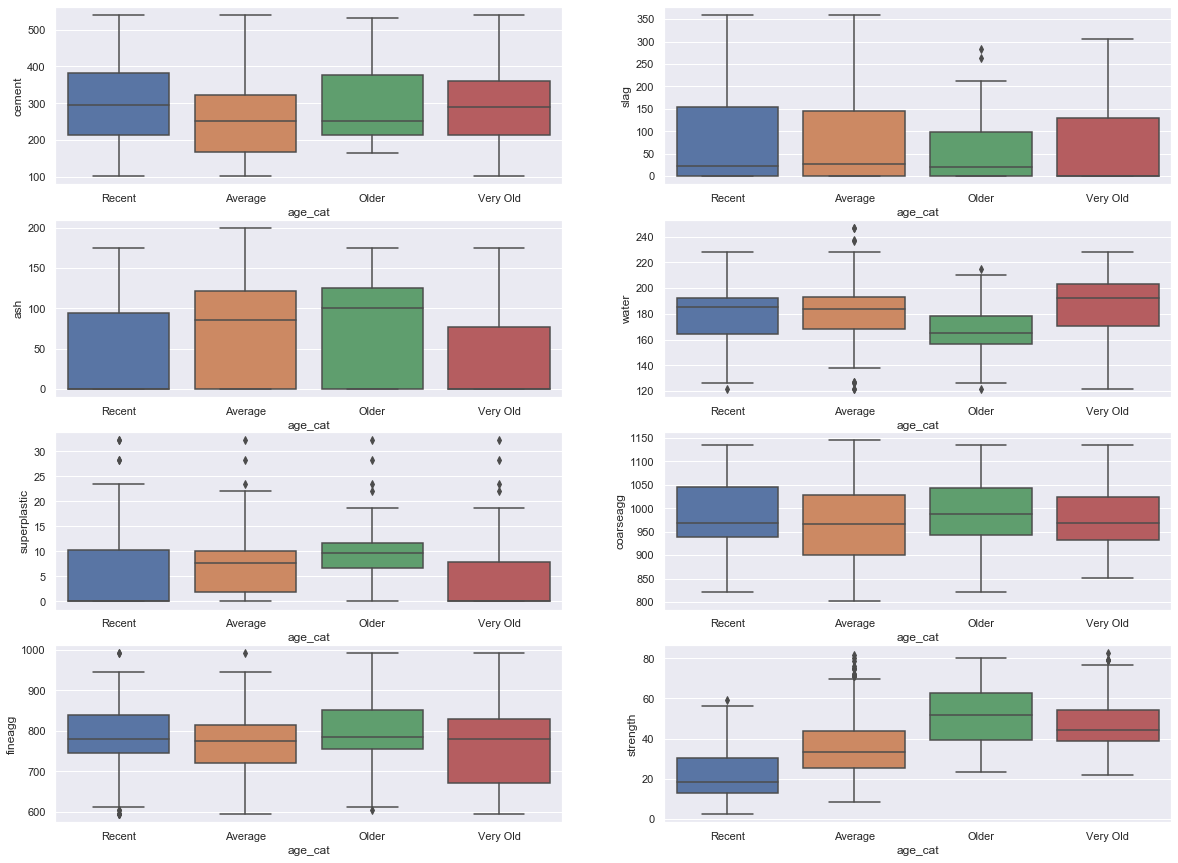

In [13]:
#Overall, there are a few outliers within the age group but I will choose to keep them in the analysis
#This is because we have so few observations the model may overfit if there is too little variability
#From the boxplots, I notice that there are significant amounts of skew. Scaling may be necessary
f, ax = plt.subplots(figsize=(20, 15), ncols=2, nrows=4)
sns.boxplot(ax=ax[0, 0], data=df, x='age_cat', y='cement')
sns.boxplot(ax=ax[0, 1], data=df, x='age_cat', y='slag')
sns.boxplot(ax=ax[1, 0], data=df, x='age_cat', y='ash')
sns.boxplot(ax=ax[1, 1], data=df, x='age_cat', y='water')
sns.boxplot(ax=ax[2, 0], data=df, x='age_cat', y='superplastic')
sns.boxplot(ax=ax[2, 1], data=df, x='age_cat', y='coarseagg')
sns.boxplot(ax=ax[3, 0], data=df, x='age_cat', y='fineagg')
sns.boxplot(ax=ax[3, 1], data=df, x='age_cat', y='strength')

In [14]:
#Since fineagg and coarseagg do not have high correlations with concrete strength, I will combine them
    #in attempt to increase it. This will be the total aggregate in the cement mixture
df['totalagg'] = df['fineagg'] + df['coarseagg']
cols = ['cement', 'slag', 'ash', 'water', 'water_cat', 'superplastic', 'coarseagg_cat', 'coarseagg',
       'fineagg', 'totalagg', 'age', 'age_cat' ,'strength']
df = df[cols]
df.head()

cement   slag    ash  water  water_cat  superplastic coarseagg_cat  \
0   141.3  212.0    0.0  203.5  Very High           0.0          High   
1   168.9   42.2  124.3  158.3        Low          10.8     Very High   
2   250.0    0.0   95.7  187.4       High           5.5       Average   
3   266.0  114.0    0.0  228.0  Very High           0.0           Low   
4   154.8  183.4    0.0  193.3  Very High           9.1     Very High   

   coarseagg  fineagg  totalagg  age  age_cat  strength  
0      971.8    748.5    1720.3   28  Average     29.89  
1     1080.8    796.2    1877.0   14  Average     23.51  
2      956.9    861.2    1818.1   28  Average     29.22  
3      932.0    670.0    1602.0   28  Average     45.85  
4     1047.4    696.7    1744.1   28  Average     18.29

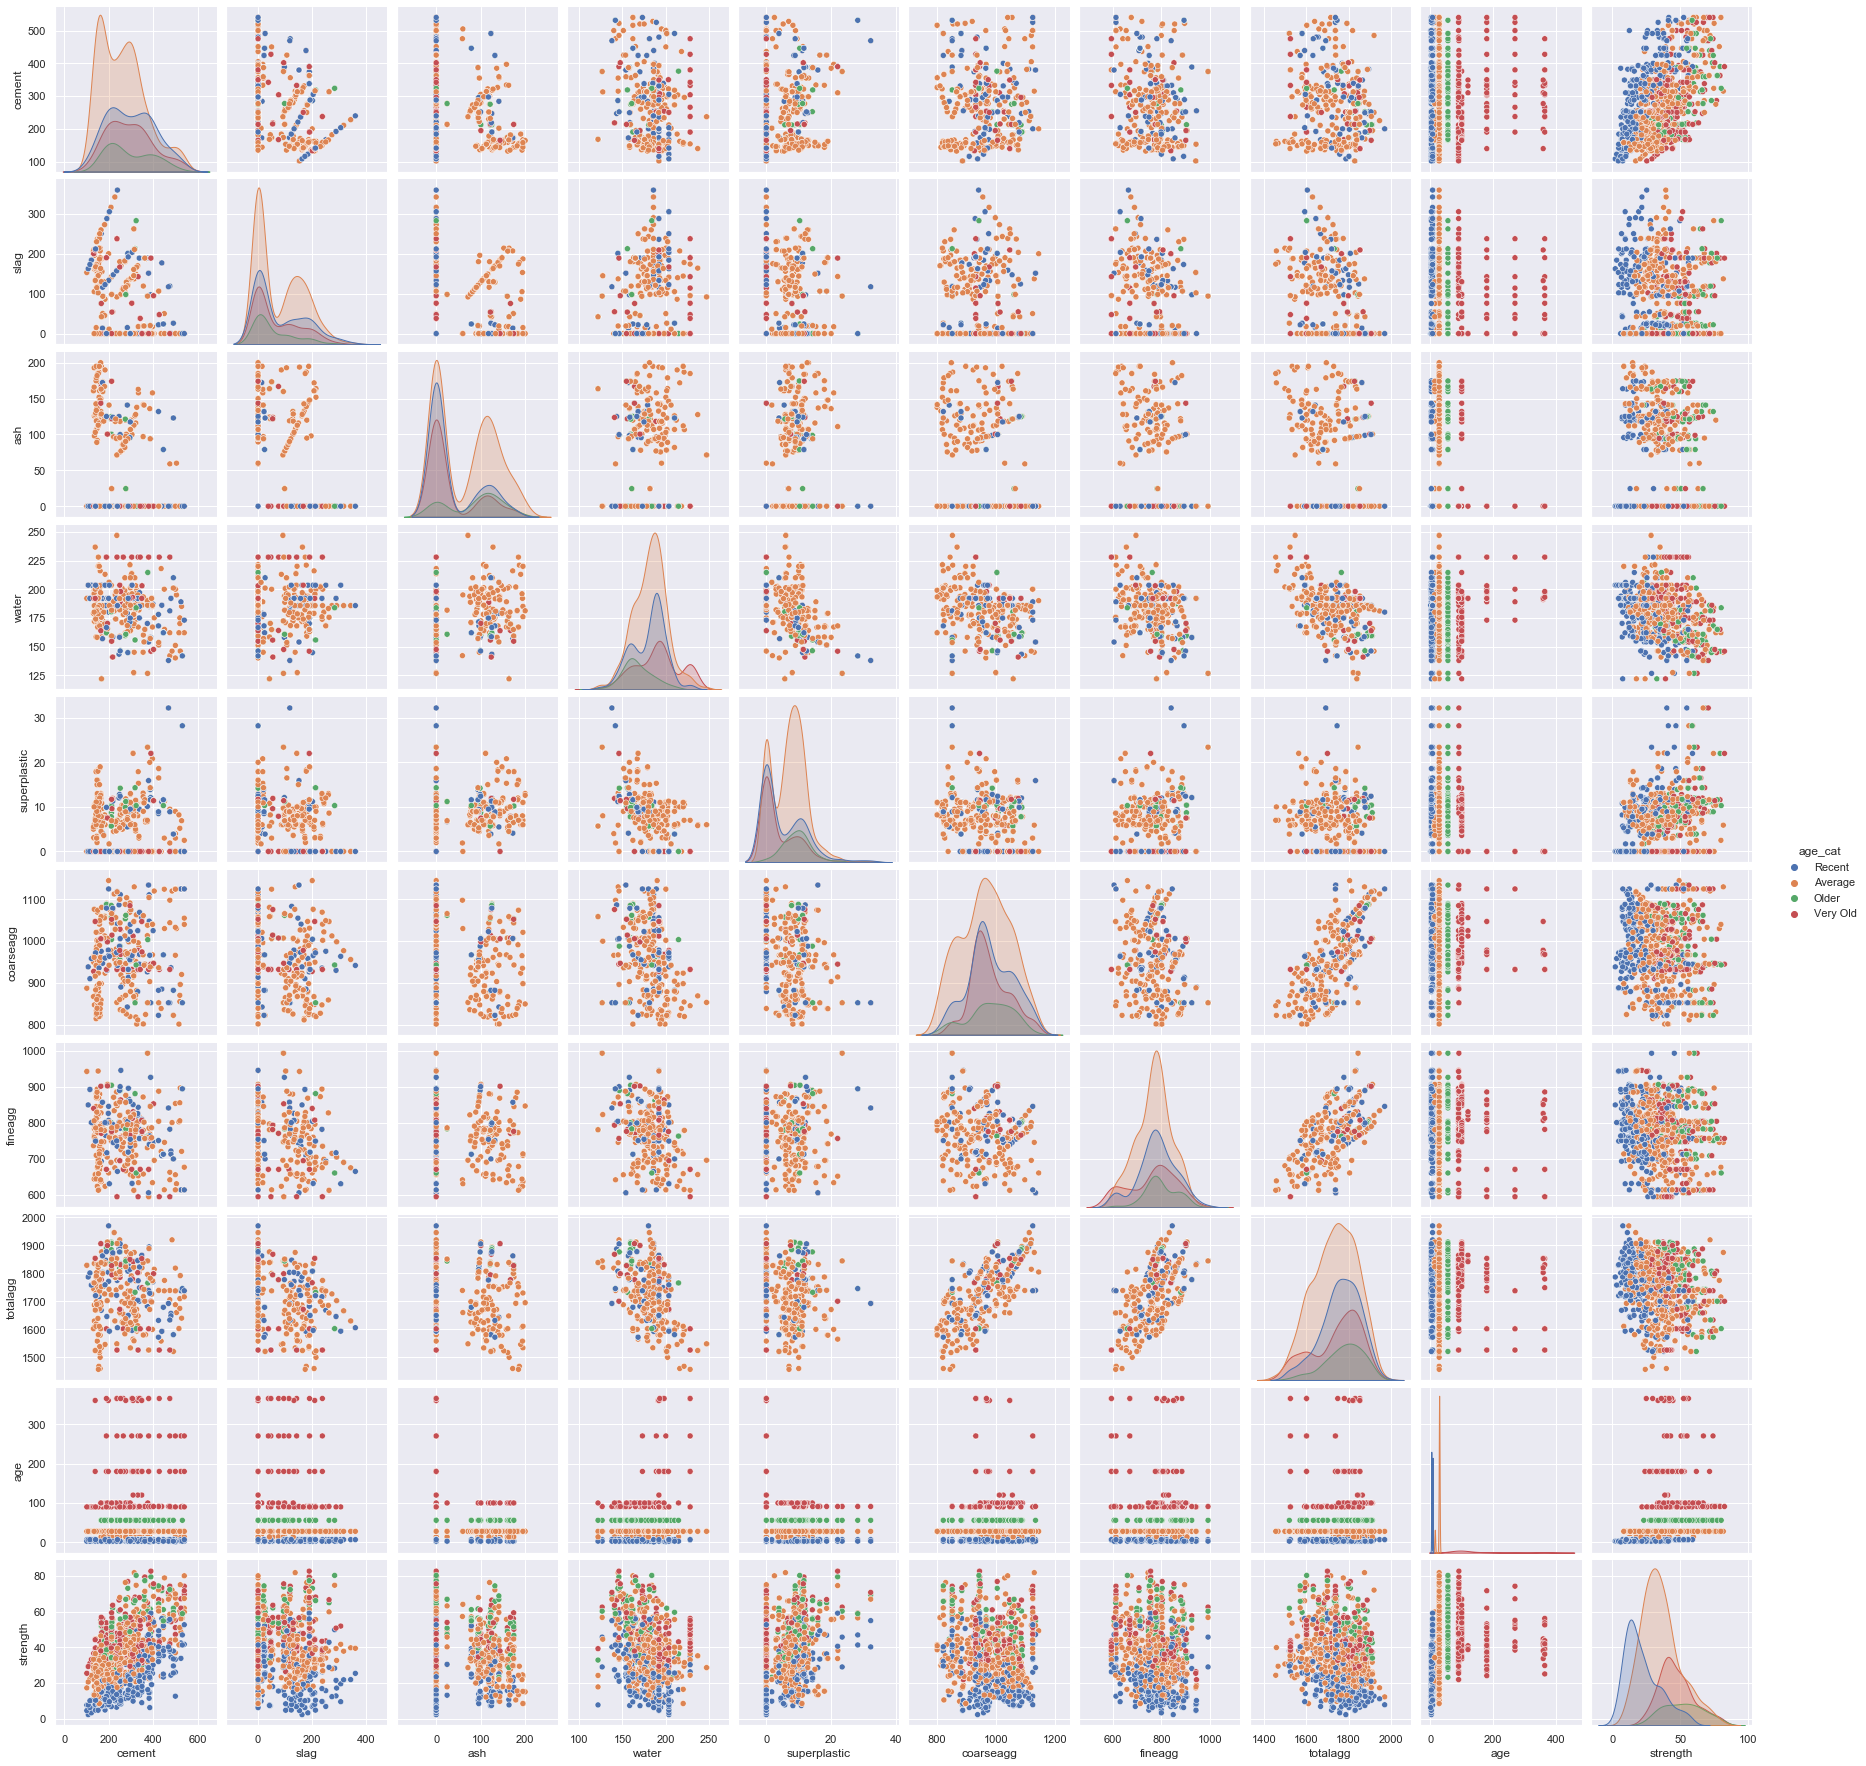

In [15]:
#Finally, I get an overall snapshot of how the numerical data looks with an age hue applied to it
#For all variables, it seems that younger aged concrete tends to have less strength overall
#This will be a good categorical variable to use in the model
sns.pairplot(df, diag_kind='kde', hue = 'age_cat')

In [16]:
#I note that the created totalagg variable increased the magnitude of correlation with the strength variable
#I choose to keep this as a predictor variable when building the model
df.corr()[['coarseagg', 'fineagg', 'totalagg']]

coarseagg   fineagg  totalagg
cement        -0.109349 -0.222718 -0.260373
slag          -0.283999 -0.281603 -0.441149
ash           -0.009961  0.079108  0.055002
water         -0.182294 -0.450661 -0.496925
superplastic  -0.265999  0.222691 -0.027935
coarseagg      1.000000 -0.178481  0.626700
fineagg       -0.178481  1.000000  0.654895
totalagg       0.626700  0.654895  1.000000
age           -0.003016 -0.156095 -0.125940
strength      -0.164935 -0.167241 -0.259130

# Predicting Concrete Strength

In [17]:
#Transforming the categorical data into numerical data
#I choose to simply replace the categorical values with numerical ones 
#Label encoding is not used since it randomly assigns numbers to each category value
#Since we have some type of order (ex. very high>high), I will manually assign the numbers
mapping1 = {'Low': 1, 'Average': 2, 'High': 3, 'Very High':4}
df = df.replace({'water_cat': mapping1, 'coarseagg_cat': mapping1})
mapping2 = {'Recent': 1, 'Average': 2, 'Older': 3, 'Very Old':4}
df = df.replace({'age_cat': mapping2})

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 
    'fineagg', 'totalagg', 'age', 'strength']] = scaler.fit_transform(df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 
    'fineagg', 'totalagg', 'age', 'strength']])

In [19]:
from sklearn.model_selection import train_test_split
#Making the training set, validation set, and testing set 60%, 20%, and 20%, respectively
X_train, X_test, y_train, y_test = train_test_split(df.drop('strength',axis=1), df['strength'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

(618, 12)
(206, 12)


In [20]:
#Note that the target variable is continuous. Hence, I must use regressor models
#I will run all the models without tuning, using default parameters first
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)
train_score = dt_model.score(X_train, y_train)
test_score = dt_model.score(X_val, y_val)
predictions = dt_model.predict(X_val)
train_pred = dt_model.predict(X_train)

In [21]:
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score,accuracy_score, mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)
results = pd.DataFrame({'Method':['Decision Tree Model'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0  Decision Tree Model        0.998942       0.799297  0.435725   

   Mean Absolute Error  
0              0.00338

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gboost_model = GradientBoostingRegressor(random_state=0)
gboost_model.fit(X_train, y_train)
train_score = gboost_model.score(X_train, y_train)
test_score = gboost_model.score(X_val, y_val)
predictions = gboost_model.predict(X_val)
train_pred = gboost_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)

In [23]:
temp = pd.DataFrame({'Method':['Gradient Boosting Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.998942       0.799297  0.435725   
0  Gradient Boosting Regressor        0.959559       0.895396  0.314565   

   Mean Absolute Error  
0             0.003380  
0             0.153746

In [24]:
from sklearn.ensemble import AdaBoostRegressor
aboost_model = AdaBoostRegressor(random_state=0)
aboost_model.fit(X_train, y_train)
train_score = aboost_model.score(X_train, y_train)
test_score = aboost_model.score(X_val, y_val)
predictions = aboost_model.predict(X_val)
train_pred = aboost_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)

In [25]:
temp = pd.DataFrame({'Method':['AdaBoost Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.998942       0.799297  0.435725   
0  Gradient Boosting Regressor        0.959559       0.895396  0.314565   
0           AdaBoost Regressor        0.835038       0.807519  0.426707   

   Mean Absolute Error  
0             0.003380  
0             0.153746  
0             0.341724

In [26]:
from sklearn.ensemble import BaggingRegressor
bag_model = BaggingRegressor(random_state=0)
bag_model.fit(X_train, y_train)
train_score = bag_model.score(X_train, y_train)
test_score = bag_model.score(X_val, y_val)
predictions = bag_model.predict(X_val)
train_pred = bag_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)

In [27]:
temp = pd.DataFrame({'Method':['Bagging Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.998942       0.799297  0.435725   
0  Gradient Boosting Regressor        0.959559       0.895396  0.314565   
0           AdaBoost Regressor        0.835038       0.807519  0.426707   
0            Bagging Regressor        0.977608       0.884346  0.330763   

   Mean Absolute Error  
0             0.003380  
0             0.153746  
0             0.341724  
0             0.098619

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_val, y_val)
predictions = rf_model.predict(X_val)
train_pred = rf_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)

In [29]:
temp = pd.DataFrame({'Method':['Random Forest Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results_untuned = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results_untuned

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.998942       0.799297  0.435725   
0  Gradient Boosting Regressor        0.959559       0.895396  0.314565   
0           AdaBoost Regressor        0.835038       0.807519  0.426707   
0            Bagging Regressor        0.977608       0.884346  0.330763   
0      Random Forest Regressor        0.983500       0.895509  0.314394   

   Mean Absolute Error  
0             0.003380  
0             0.153746  
0             0.341724  
0             0.098619  
0             0.089934

Insights: We can see that the random forest regressor has the best performance, although overfitting is occurring. This model also has the lowest RMSE. The decision tree model possesses the least mean absolute error. This model's train accuracy is very high although the test accuracy is not as high as the gradient boosting regressor or the random forest regressor. This means that the decision tree regressor is overfitting to the training set as well. The adaboost regressor performed the worst and has the highest errors. All other models are quite prone to overfitting however. Now, I will tune this models in order to reduce overfitting and make these models perform even better.

# Hyperparameter Tuning

Decision Tree Regressor

In [30]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
clf = DecisionTreeRegressor(random_state = 0)
param_dist = {"max_depth": sp_randint(1, 101),
              "max_features": sp_randint(1, 51),
              "min_samples_split": sp_randint(2, 51),
              "min_samples_leaf": sp_randint(1, 51),
              "criterion": ["gini", "entropy", "mse"]}
samples = 200  # number of random samples 
dt_randomCV = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = samples, random_state = 0)
dt_randomCV.fit(X_val, y_val)
print(dt_randomCV.best_params_)
dt_randomCV.best_estimator_

{'criterion': 'mse', 'max_depth': 18, 'max_features': 7, 'min_samples_leaf': 8, 'min_samples_split': 20}


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=18,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [31]:
dt_model = dt_randomCV.best_estimator_
dt_model.fit(X_train, y_train)
train_score = dt_model.score(X_train, y_train)
test_score = dt_model.score(X_val, y_val)
predictions = dt_model.predict(X_val)
train_pred = dt_model.predict(X_train)

In [32]:
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)
results = pd.DataFrame({'Method':['Decision Tree Model'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0  Decision Tree Model        0.875123       0.752603  0.483764   

   Mean Absolute Error  
0             0.263451

Gradient Boosting Regressor

In [33]:
clf = GradientBoostingRegressor(random_state = 0)
param_dist = {"max_depth": sp_randint(1, 101),
              "max_features": sp_randint(1, 51),
              "min_samples_split": sp_randint(2, 51),
              "min_samples_leaf": sp_randint(1, 51),
              "criterion": ["gini", "entropy", "friedman_mse"]}
samples = 100  # number of random samples 
gb_randomCV = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = samples, random_state = 0)
gb_randomCV.fit(X_val, y_val)
print(gb_randomCV.best_params_)

{'criterion': 'friedman_mse', 'max_depth': 62, 'max_features': 6, 'min_samples_leaf': 24, 'min_samples_split': 45}


In [34]:
gboost_model = gb_randomCV.best_estimator_
gboost_model.fit(X_train, y_train)
train_score = gboost_model.score(X_train, y_train)
test_score = gboost_model.score(X_val, y_val)
predictions = gboost_model.predict(X_val)
train_pred = gboost_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)
temp = pd.DataFrame({'Method':['Gradient Boosting Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.875123       0.752603  0.483764   
0  Gradient Boosting Regressor        0.977237       0.903414  0.302269   

   Mean Absolute Error  
0             0.263451  
0             0.107190

Adaboost Regressor

In [35]:
clf = AdaBoostRegressor(random_state = 0)
param_dist = {"n_estimators": sp_randint(1, 101),
              "learning_rate": sp_randint(1, 51),
              "loss": ["linear", "square", "exponential"]}
samples = 100  # number of random samples 
ab_randomCV = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = samples, random_state = 0)
ab_randomCV.fit(X_val, y_val)
print(ab_randomCV.best_params_)

{'learning_rate': 2, 'loss': 'exponential', 'n_estimators': 40}


In [36]:
aboost_model = ab_randomCV.best_estimator_
aboost_model.fit(X_train, y_train)
train_score = aboost_model.score(X_train, y_train)
test_score = aboost_model.score(X_val, y_val)
predictions = aboost_model.predict(X_val)
train_pred = aboost_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)
temp = pd.DataFrame({'Method':['AdaBoost Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.875123       0.752603  0.483764   
0  Gradient Boosting Regressor        0.977237       0.903414  0.302269   
0           AdaBoost Regressor        0.832999       0.807737  0.426465   

   Mean Absolute Error  
0             0.263451  
0             0.107190  
0             0.344464

Bagging Regressor

In [37]:
clf = BaggingRegressor(random_state = 0)
param_dist = {"n_estimators": sp_randint(1, 101),
              "max_samples": sp_randint(1, 51),
              "bootstrap": [True, False],
             "warm_start": [True, False]}
samples = 100  # number of random samples 
bag_randomCV = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = samples, random_state = 0)
bag_randomCV.fit(X_val, y_val)
print(bag_randomCV.best_params_)

{'bootstrap': False, 'max_samples': 48, 'n_estimators': 65, 'warm_start': True}


In [38]:
bag_model = bag_randomCV.best_estimator_
bag_model.fit(X_train, y_train)
train_score = bag_model.score(X_train, y_train)
test_score = bag_model.score(X_val, y_val)
predictions = bag_model.predict(X_val)
train_pred = bag_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)
temp = pd.DataFrame({'Method':['Bagging Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]
results

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.875123       0.752603  0.483764   
0  Gradient Boosting Regressor        0.977237       0.903414  0.302269   
0           AdaBoost Regressor        0.832999       0.807737  0.426465   
0            Bagging Regressor        0.758000       0.854537  0.370948   

   Mean Absolute Error  
0             0.263451  
0             0.107190  
0             0.344464  
0             0.390181

Random Forest Regressor

In [39]:
clf = RandomForestRegressor(random_state = 0)
param_dist = {"max_depth": [None, 3, 5, 10, 15],
              "max_features": sp_randint(1, 51),
              "min_samples_split": sp_randint(2, 51),
              "min_samples_leaf": sp_randint(1, 51),
              "criterion": ["gini", "entropy", "mse"]}
samples = 100  # number of random samples 
rf_randomCV = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = samples, random_state = 0)
rf_randomCV.fit(X_val, y_val)
print(rf_randomCV.best_params_)

{'criterion': 'mse', 'max_depth': 15, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 23}


In [40]:
rf_model = rf_randomCV.best_estimator_
rf_model.fit(X_train, y_train)
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_val, y_val)
predictions = rf_model.predict(X_val)
train_pred = rf_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
mae = mean_absolute_error(train_pred, y_train)
temp = pd.DataFrame({'Method':['Random Forest Regressor'], 'Train Accuracy': [train_score], 
                    'Test Accuracy': [test_score], 'RMSE': [rmse], 'Mean Absolute Error': [mae]})
results = pd.concat([results, temp])
results_tuned = results[['Method', 'Train Accuracy', 'Test Accuracy', 'RMSE', 'Mean Absolute Error']]

In [41]:
results_untuned

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.998942       0.799297  0.435725   
0  Gradient Boosting Regressor        0.959559       0.895396  0.314565   
0           AdaBoost Regressor        0.835038       0.807519  0.426707   
0            Bagging Regressor        0.977608       0.884346  0.330763   
0      Random Forest Regressor        0.983500       0.895509  0.314394   

   Mean Absolute Error  
0             0.003380  
0             0.153746  
0             0.341724  
0             0.098619  
0             0.089934

In [42]:
results_tuned

Method  Train Accuracy  Test Accuracy      RMSE  \
0          Decision Tree Model        0.875123       0.752603  0.483764   
0  Gradient Boosting Regressor        0.977237       0.903414  0.302269   
0           AdaBoost Regressor        0.832999       0.807737  0.426465   
0            Bagging Regressor        0.758000       0.854537  0.370948   
0      Random Forest Regressor        0.894507       0.847140  0.380262   

   Mean Absolute Error  
0             0.263451  
0             0.107190  
0             0.344464  
0             0.390181  
0             0.250296

Insights: In the untuned batch of models, it is very clear to see that overfitting is occurring. This is because the training accuracy is incredibly high, which will lead to adverse consequences when the models see data it has never seen before. After tuning, we see that these training accuracies fell down to an appropriate level, reducing the extent of overfitting. The gradient boosting regressor and adaboost regressor had higher accuracy in the test set after tuning as well, with reduced RMSE values. Overfitting is still a problem in the gradient boosting regressor even after tuning however. Although some test accuracies in the tuned models went down, overfitting was reduced by a large margin, ensuring that performance will remain high for unseen data. Thus far, we have used the validation set as our testing set. My models have not seen the testing data yet. Thus, I finally run K-fold cross validation in order to observe how these tuned models perform on new data

# K-Fold Cross Validation

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [44]:
kfold = KFold(n_splits= 4, random_state= 0)
model = dt_randomCV.best_estimator_
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Decision Tree Regressor Accuracy: %.3f%%, SD: (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Decision Tree Regressor Accuracy: 56.618%, SD: (3.951%)


In [45]:
kfold = KFold(n_splits= 4, random_state= 0)
model = gb_randomCV.best_estimator_
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Gradient Boosting Regressor Accuracy: %.3f%%, SD: (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Gradient Boosting Regressor Accuracy: 81.664%, SD: (2.648%)


In [46]:
kfold = KFold(n_splits= 4, random_state= 0)
model = ab_randomCV.best_estimator_
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("AdaBoost Regressor Accuracy: %.3f%%, SD: (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

AdaBoost Regressor Accuracy: 76.023%, SD: (1.223%)


In [47]:
kfold = KFold(n_splits= 4, random_state= 0)
model = bag_randomCV.best_estimator_
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Bagging Regressor Accuracy: %.3f%%, SD: (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Bagging Regressor Accuracy: 78.483%, SD: (0.646%)


In [48]:
kfold = KFold(n_splits= 4, random_state= 0)
model = rf_randomCV.best_estimator_
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Random Forest Regressor Accuracy: %.3f%%, SD: (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Random Forest Regressor Accuracy: 71.964%, SD: (0.894%)


Insights: As one can see, the gradient boosting regressor model performs the best out of all of the tested models. Thus, this would be an ideal model to use in order to predict concrete strength. This model tends to overfit, yet performs well on unseen data despite this. On the other hand, the decision tree regressor was by far the worst model. This is due to its inherent nature to overfit. If this model were to be implemented, proper pruning must be done in order to prevent overfitting. The bagging regressor model is also a strong candidate to use for this supervised learning problem.